In [ ]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csr import csr_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Let's us read the input data
df = pd.read_csv('/content/drive/MyDrive/TFM/data/export_licitaciones_cleaned.csv', sep=',', encoding='UTF8')
df.head()

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text
0,32500000,32000000,32500000.0,NaN,NaN,Adquisición de repuestos para el ILS AMS 2100,adquisición repuesto
1,65310000,65000000,65300000.0,65310000.0,NaN,Suministro de energía eléctrica en el Centro d...,suministrar energía eléctrico centrar conserva...
2,92112000,92000000,92100000.0,92110000.0,92112000.0,"Servicio de duplicado de copias de películas, ...",servicio duplicar copiar película tráiler vide...
3,9122110,9000000,9100000.0,9120000.0,9122000.0,Gas Licuado Propano 2013/2014,licuar propano
4,75000000,75000000,NaN,NaN,NaN,Servicio de vigilancia del Centro Cultural de ...,servicio vigilancia centrar cultural españa mé...


In [ ]:
df.isnull().sum()

id_cpv               0
id_division          0
id_grupo         42853
id_clase        104911
id_categoria    193456
objeto               0
clean_text           0
dtype: int64

In [ ]:
#Vemos aquellos registros que al preprocesar la descripción se vuelve nulo
df[df['clean_text'].isnull()]

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text


In [ ]:
df = df.sample(n=500000, random_state=1)
df

,id_capitulo,id_concepto,id_partida_generica,descripcion
246729,2000,2500,2530,Infliximab SOLUCIÓN INYECTABLE El frasco ámpul...
71686,3000,3200,3250,SERVICIO DE ARRENDAMIENTO INTEGRAL DE VEHÍCULO...
26815,6000,6100,6150,Invitación E350-2018 Seguimiento y control par...
294323,3000,3500,3510,TRABAJOS DE REHABILTACIÓN Y MANTTO. EN LA ESTA...
224244,2000,2500,2530,ADQUISICION DE INSUMOS DE LISOSOMALES (IDURSUL...
...,...,...,...,...
543834,2000,2500,2530,E297-2021 - ADQUISICION DE MEDICAMENTO Y ESTUP...
55834,5000,5300,5310,AA-050GYR017-E80-2018 ADQUISICIÓN DE EQUIPOS M...
451835,3000,3300,3360,SERVICIO DE IMPRESION DE TRIPTICOS INFORMATIVOS
582010,2000,2500,2540,SDI INVESTIGACIÓN DE MERCADO GPO 379


In [ ]:
df.groupby(['id_division']).count()['objeto']

id_division
3000000      3209
9000000      7625
14000000     1009
15000000     4085
16000000      572
18000000     3762
19000000      526
22000000     2710
24000000     2344
30000000     9438
31000000     5062
32000000     3944
33000000    20280
34000000    17050
35000000     5019
37000000     1466
38000000     6610
39000000     6629
41000000      151
42000000     5445
43000000      750
44000000     8228
45000000    65265
48000000     8038
50000000    29686
51000000      897
55000000     9723
60000000     8086
63000000     3208
64000000     3330
65000000      627
66000000     6733
70000000     3343
71000000    20358
72000000    19244
73000000     2101
75000000     1586
76000000       39
77000000     3693
79000000    26186
80000000     6814
85000000    17495
90000000    15482
92000000    14354
98000000     4992
Name: objeto, dtype: int64

In [ ]:
#Preprocessing for word2vect
def preprocessing(sentence):
  return gensim.utils.simple_preprocess(sentence, deacc=True, min_len=3, max_len=15)

In [ ]:
#Preprocessing for word2vect
df['clean_text'] = df['clean_text'].apply(lambda description: preprocessing(description))
df

,id_cpv,id_division,id_grupo,id_clase,id_categoria,objeto,clean_text
0,32500000,32000000,32500000.0,NaN,NaN,Adquisición de repuestos para el ILS AMS 2100,"[adquisicion, repuesto]"
1,65310000,65000000,65300000.0,65310000.0,NaN,Suministro de energía eléctrica en el Centro d...,"[suministrar, energia, electrico, centrar, con..."
2,92112000,92000000,92100000.0,92110000.0,92112000.0,"Servicio de duplicado de copias de películas, ...","[servicio, duplicar, copiar, pelicula, trailer..."
3,9122110,9000000,9100000.0,9120000.0,9122000.0,Gas Licuado Propano 2013/2014,"[licuar, propano]"
4,75000000,75000000,NaN,NaN,NaN,Servicio de vigilancia del Centro Cultural de ...,"[servicio, vigilancia, centrar, cultural, espa..."
...,...,...,...,...,...,...,...
387189,70310000,70000000,70300000.0,70310000.0,NaN,"Arrendamiento cafetería, aseos y vestuarios de...","[arrendamiento, cafeteria, aseo, vestuario, ed..."
387190,90911000,90000000,90900000.0,90910000.0,90911000.0,Contrato basado en Acuerdo Marco servicio de l...,"[contratar, basar, acordar, marcar, servicio, ..."
387191,85100000,85000000,85100000.0,NaN,NaN,Servicio de prevención ajeno para el Instituto...,"[servicio, prevencion, ajeno, instituto, munic..."
387192,34631000,34000000,34600000.0,34630000.0,34631000.0,Certificacion conjunto pivote y tubo guia,"[certificacion, conjuntar, pivotar, tubo, guia]"


In [ ]:
w2v_model=gensim.models.Word2Vec(df['clean_text'], size=100, window=8, min_count=1, sg=1, iter=20, seed=1852)
w2v_model.train(df['clean_text'], total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(68868256, 76860020)

In [ ]:
#we can extract the generated word embeddings 
w2v_embeddings=w2v_model.wv

In [ ]:
#the vocabulary represented by the W2V model
w2v_vocabulary=w2v_embeddings.vocab.keys()

In [ ]:
len(w2v_vocabulary)

69354

In [ ]:
w2v_vocabulary

dict_keys(['adquisicion', 'repuesto', 'suministrar', 'energia', 'electrico', 'centrar', 'conservacion', 'restauracion', 'filmoteca', 'espanolar', 'servicio', 'duplicar', 'copiar', 'pelicula', 'trailer', 'videocasete', 'material', 'cinematografico', 'licuar', 'propano', 'vigilancia', 'cultural', 'espana', 'mexico', 'realizacion', 'actividad', 'atencion', 'publico', 'museo', 'ferrocarril', 'geltru', 'vehiculo', 'varios', 'marcar', 'dotacion', 'sistema', 'motor', 'vehicular', 'proyectar', 'mejorar', 'infraestructura', 'instalacion', 'modernizacion', 'regadio', 'finca', 'valdeojos', 'hornillo', 'termino', 'municipal', 'lebrija', 'sevilla', 'mencionar', 'prever', 'financiar', 'fondo', 'europeo', 'desarrollar', 'regional', 'feder', 'informatico', 'materia', 'primo', 'alimentacion', 'interno', 'centro', 'penitenciario', 'algeciras', 'puerto', 'alcala', 'guadaira', 'cordoba', 'huelva', 'albolote', 'almeria', 'jaen', 'malaga', 'castellon', 'valencia', 'caceres', 'badajoz', 'procedente', 'fuente

In [ ]:
#Para vectorizar una sentencia se promedia cada el vectodr generado con el word2vec model para cada palabra
def vectorize_sentence(sentence,model):
    a = []
    for i in sentence:
        try:
            a.append(model.get_vector(str(i)))
        except:
            pass
        
    a=np.array(a).mean(axis=0)
    a = np.zeros(100) if np.all(a!=a) else a
    return a

In [ ]:
word="software"
w2v_embeddings.most_similar(positive=word)

[('licenciar', 0.8434050679206848),
 ('hardware', 0.7937197089195251),
 ('soportar', 0.7926208972930908),
 ('alienvault', 0.7410697340965271),
 ('datamodeler', 0.7375491857528687),
 ('actiualizacion', 0.7375223636627197),
 ('docuware', 0.7340313196182251),
 ('eplan', 0.7270406484603882),
 ('oracle', 0.724956750869751),
 ('ysoftware', 0.7234656810760498)]

In [ ]:
#Vector for a word
w2v_embeddings.get_vector('solucion')

array([-0.4055125 , -0.3249059 ,  0.78679514, -0.47073433,  0.12460108,
        0.18912183,  0.02446099,  0.26022607, -0.00353078, -0.02565594,
        0.55794215, -0.15789981, -0.564683  ,  0.5198979 , -0.12411992,
       -0.47662354, -0.18878633, -0.29784122,  0.7471837 , -0.18225612,
        0.3516557 , -0.7070995 ,  0.8307887 , -0.19578436,  0.53434634,
       -0.18022752, -0.77589786, -0.34984258, -0.43631145,  0.16852589,
        0.47060868,  0.6218065 , -0.45614728,  0.36333466,  0.37701744,
        0.0502185 , -0.04353554,  0.6804887 , -0.14185765, -0.29441357,
        0.24287769, -0.08348549,  0.04707614,  0.09463938,  0.18859354,
       -0.5849048 ,  0.16550437, -0.04939263, -0.26574174,  0.02362669,
       -0.15402739,  0.24127173,  0.05641996, -0.08465634, -0.08285752,
       -0.01802287, -0.5139148 ,  0.3750453 , -0.35045508,  0.04617619,
       -0.08754495, -0.3356796 , -0.49513936, -0.17838672, -0.22547822,
        0.08269832,  0.6603445 , -0.782438  ,  0.47169825,  0.73

In [ ]:
print(len(w2v_embeddings.get_vector('servicio')))

100


In [ ]:
vectorize_sentence(df['clean_text'].values[0], w2v_embeddings)

array([ 6.44322097e-01, -1.59176648e-01,  1.35451794e-01,  3.35743017e-02,
       -8.07522535e-02,  1.80588022e-01, -1.22862443e-01,  1.67931378e-01,
       -1.99190587e-01,  6.18069768e-01,  2.68296063e-01,  2.43524075e-01,
       -5.09437658e-02,  7.13264942e-02,  1.48585320e-01,  3.68942440e-01,
       -3.71351317e-02, -3.07380021e-01,  2.29129530e-02,  1.39811337e-01,
       -1.58315878e-02,  1.45598531e-01,  8.17637891e-02,  2.58449316e-02,
        4.00556237e-01,  3.72559100e-01, -2.29210153e-01,  4.61862423e-02,
        3.95816267e-01, -2.82026947e-01,  8.65992308e-02, -1.38177663e-01,
        2.05359831e-02,  3.44817191e-01,  2.61985958e-01, -8.03270638e-02,
        1.21824473e-01,  1.09565258e-02,  2.41586298e-01,  1.18753552e-01,
       -3.51984054e-02, -3.38867307e-01,  3.10821831e-01, -1.11733928e-01,
        1.80051416e-01, -3.20873946e-01, -3.00817788e-02,  5.34786880e-02,
       -8.94398764e-02,  1.31606907e-01, -1.11981392e-01, -3.32973748e-01,
       -1.15743123e-01, -

In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_division'] # Labels

In [ ]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/1000000.0)))

In [ ]:
X = X.apply(lambda description: vectorize_sentence(description, w2v_embeddings))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#to sparse matrix
X_vect = csr_matrix(pd.DataFrame(np.vstack(X)))

In [ ]:
X_vect

<387194x100 sparse matrix of type '<class 'numpy.float64'>'
	with 38715300 stored elements in Compressed Sparse Row format>

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X_vect, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
X_train

<309755x100 sparse matrix of type '<class 'numpy.float64'>'
	with 30971800 stored elements in Compressed Sparse Row format>

In [ ]:
def multi_label_metrics(y_true,y_pred):
    # compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
   
    # return as dictionary
    metrics = {'balanced_accuracy_score': balanced_accuracy,
               'accuracy': accuracy}
    return metrics

In [ ]:
def describe_performance(gridSearchCVModel, y_test, y_pred):
  print("Best parameters set found on training set:")
  print()
  print("best parameters: ",gridSearchCVModel.best_params_)
  print()
  print("Grid scores on testing set:")
  print()
  means_score = gridSearchCVModel.cv_results_["mean_test_score"]
  stds_scroe = gridSearchCVModel.cv_results_["std_test_score"]
  for mean, std, params in zip(means_score, stds_scroe, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("best score: ", gridSearchCVModel.best_score_)
  print()
  print("Grid times on testing set:")
  print()
  means_fit_time = gridSearchCVModel.cv_results_["mean_fit_time"]
  std_fit_time = gridSearchCVModel.cv_results_["std_fit_time"]
  for mean, std, params in zip(means_fit_time, std_fit_time, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f seconds (+/-%0.03f) for %r" % (mean, std * 2, params))
  print("Detailed classification report:")
  print()
  print("The model is trained on the full training set.")
  print("The scores are computed on the full testing set.")
  print()
  print(multi_label_metrics(y_test, y_pred))
  print(metrics.classification_report(y_test, y_pred))
  print()

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix test
  plt.clf()
  fig,ax = plt.subplots(figsize=(22,22))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
  plt.show() 

## Scalers

In [ ]:
from sklearn.preprocessing import StandardScaler 
#removes the mean and scales the data to unit variance. [-0.2, 0.2] range
scaler = StandardScaler(with_mean=False).fit(X_vect)
X_train_SS = scaler.transform(X_train)
X_test_SS = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler  
#is similar to MinMaxScaler except that the values are mapped across several ranges depending on whether negative OR positive values are present.
#[0, 1],  [-1, 0],  [-1, 1]
scaler = MaxAbsScaler ().fit(X_vect)
X_train_MAS = scaler.fit_transform(X_train)
X_test_MAS = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_centering=False).fit(X_vect)
X_train_RS = scaler.fit_transform(X_train)
X_test_RS = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#rescales the data set such that all feature values are in the range [0, 1]
scaler = MinMaxScaler().fit(X_vect.toarray())
X_train_MM = scaler.fit_transform(X_train.toarray())
X_test_MM = scaler.transform(X_test.toarray())
X_total_MM = scaler.transform(X_vect.toarray())

##MultinomialNB


In [ ]:
from sklearn.naive_bayes import GaussianNB
parametersMNB = { 
                 'var_smoothing':[1e-9]
                }
modelMNB = GaussianNB()

In [ ]:
#Model and hyperparameters
parametersMNB = { 
                 'alpha':[0, 0.5, 1.0]
                }
modelMNB = MultinomialNB()

In [ ]:
clf_MNB_GS = GridSearchCV(modelMNB, parametersMNB, cv=3, n_jobs=-1, verbose=3)
clf_MNB_GS.fit(X_train_SS.toarray(), y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09]}, verbose=3)

In [ ]:
# Let's see the results
y_pred = clf_MNB_GS.predict(X_test_SS.toarray())

In [ ]:
#Model performance
describe_performance(clf_MNB_GS, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'var_smoothing': 1e-09}

Grid scores on testing set:

0.545 (+/-0.002) for {'var_smoothing': 1e-09}

best score:  0.5453438968131943

Grid times on testing set:

0.971 seconds (+/-0.372) for {'var_smoothing': 1e-09}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.4757744019062662, 'accuracy': 0.544351037590878}
              precision    recall  f1-score   support

     3000000       0.62      0.56      0.59       642
     9000000       0.63      0.75      0.68      1525
    14000000       0.23      0.54      0.32       202
    15000000       0.61      0.59      0.60       817
    16000000       0.21      0.57      0.31       114
    18000000       0.46      0.57      0.51       752
    19000000       0.07      0.37      0.11       105
    22000000       0.41      0.58      0.48       542
    24000000       0.27  

##LinearSVC

In [ ]:
#For large datasets consider using LinearSVC = SGDClassifier with loss hinge and penalty l2
parametersSVM = { 
                 'max_iter':[100, 500, 1000, 1500]
                 }
modelSVM = SGDClassifier(loss='hinge', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [ ]:
#Model and hyperparameters
clf_GS_SVM = GridSearchCV(modelSVM, parametersSVM, cv=2, n_jobs=-1, verbose=10)
clf_GS_SVM.fit(X_train_SS, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
Norm: 10.36, NNZs: 100, Bias: -0.680348, T: 278779, Avg. loss: 0.386710
Total training time: 0.23 seconds.
-- Epoch 1
-- Epoch 2
Norm: 19.45, NNZs: 100, Bias: -0.843287, T: 278779, Avg. loss: 0.972875
Total training time: 0.23 seconds.
Norm: 6.17, NNZs: 100, Bias: -0.718498, T: 557558, Avg. loss: 0.059071
Total training time: 0.63 seconds.
-- Epoch 2
-- Epoch 3
Norm: 10.42, NNZs: 100, Bias: -0.868230, T: 557558, Avg. loss: 0.115391
Total training time: 0.63 seconds.
Norm: 4.26, NNZs: 100, Bias: -0.741084, T: 836337, Avg. loss: 0.041028
Total training time: 1.00 seconds.
-- Epoch 3
-- Epoch 4
Norm: 7.71, NNZs: 100, Bias: -0.885595, T: 836337, Avg. loss: 0.071807
Total training time: 1.04 seconds.
Norm: 3.58, NNZs: 100, Bias: -0.756965, T: 1115116, Avg. loss: 0.033453
Total training time: 1.37 seconds.
-- Epoch 4
-- Epoch 5
Norm: 6.08, NNZs: 100, Bias: -0.896862, T: 1115116, Avg. loss: 0.054889
Total training time: 1.45 seconds.
Norm: 3.32, NNZs: 100, Bias: -0.769311, T: 13938

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.0s


Convergence after 6 epochs took 2.44 seconds
-- Epoch 1
Norm: 3.25, NNZs: 100, Bias: -0.309681, T: 278779, Avg. loss: 1.053095
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 6.34, NNZs: 100, Bias: -0.524237, T: 278779, Avg. loss: 0.308987
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 1.96, NNZs: 100, Bias: -0.356067, T: 557558, Avg. loss: 0.232108
Total training time: 0.68 seconds.
-- Epoch 3
Norm: 3.79, NNZs: 100, Bias: -0.562489, T: 557558, Avg. loss: 0.060753
Total training time: 0.63 seconds.
-- Epoch 3
Norm: 1.41, NNZs: 100, Bias: -0.381906, T: 836337, Avg. loss: 0.184937
Total training time: 1.08 seconds.
-- Epoch 4
Norm: 3.02, NNZs: 100, Bias: -0.585490, T: 836337, Avg. loss: 0.045351
Total training time: 1.02 seconds.
-- Epoch 4
Norm: 1.25, NNZs: 100, Bias: -0.401273, T: 1115116, Avg. loss: 0.165480
Total training time: 1.50 seconds.
Norm: 2.45, NNZs: 100, Bias: -0.601691, T: 1115116, Avg. loss: 0.039059
Total training time: 1.42 seconds.
-- Epoch 5
-- Epoch 5
Norm: 

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   59.5s finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, n_jobs=-1,
                                     random_state=42, verbose=2),
             n_jobs=-1, param_grid={'max_iter': [100, 500, 1000, 1500]},
             verbose=10)

In [ ]:
# Let's see the results
y_pred = clf_GS_SVM.predict(X_test_SS)

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'max_iter': 100}

Grid scores on testing set:

0.502 (+/-0.069) for {'max_iter': 100}
0.502 (+/-0.069) for {'max_iter': 500}
0.502 (+/-0.069) for {'max_iter': 1000}
0.502 (+/-0.069) for {'max_iter': 1500}

best score:  0.5016417316388412

Grid times on testing set:

64.764 seconds (+/-0.093) for {'max_iter': 100}
54.108 seconds (+/-0.761) for {'max_iter': 500}
54.456 seconds (+/-1.270) for {'max_iter': 1000}
53.375 seconds (+/-0.559) for {'max_iter': 1500}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.4564168703508423, 'accuracy': 0.5426722969046605}
              precision    recall  f1-score   support

          14       0.17      0.46      0.25       202
          15       0.76      0.55      0.63       817
          16       0.48      0.25      0.33       114
          18       0.63      0.56      0.59      

In [ ]:
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 0.1, 'max_iter': 10}

Grid scores on testing set:

0.567 (+/-0.034) for {'C': 0.1, 'max_iter': 10}
0.551 (+/-0.015) for {'C': 1, 'max_iter': 10}

best score:  0.5670706949084829

Grid times on testing set:

68.909 seconds (+/-0.401) for {'C': 0.1, 'max_iter': 10}
68.709 seconds (+/-0.066) for {'C': 1, 'max_iter': 10}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.43083733399466184, 'accuracy': 0.6124304291119462}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     3000000       0.53      0.69      0.60       642
     9000000       0.69      0.85      0.76      1525
    14000000       0.50      0.17      0.26       202
    15000000       0.64      0.69      0.66       817
    16000000       0.45      0.34      0.39       114
    18000000       0.61      0.56      0.58       752
    19000000       0.50      0.03      0.05       105
    22000000       0.52      0.47      0.49       542
    24000000       0.20      0.62      0.30       469
    30000000       0.62      0.41      0.50      1888
    31000000       0.25      0.25      0.25      1012
    32000000       0.31      0.18      0.23       789
    33000000       0.65      0.86      0.74      4056
    34000000       0.59      0.60      0.60      3410
    35000000       0.19      0.40      0.26      1004
    37000000       0.57      0.26      0.36       293
    38000000       0.48      0.62      0.54      1322
    39000000       0.46    

<Figure size 432x288 with 0 Axes>

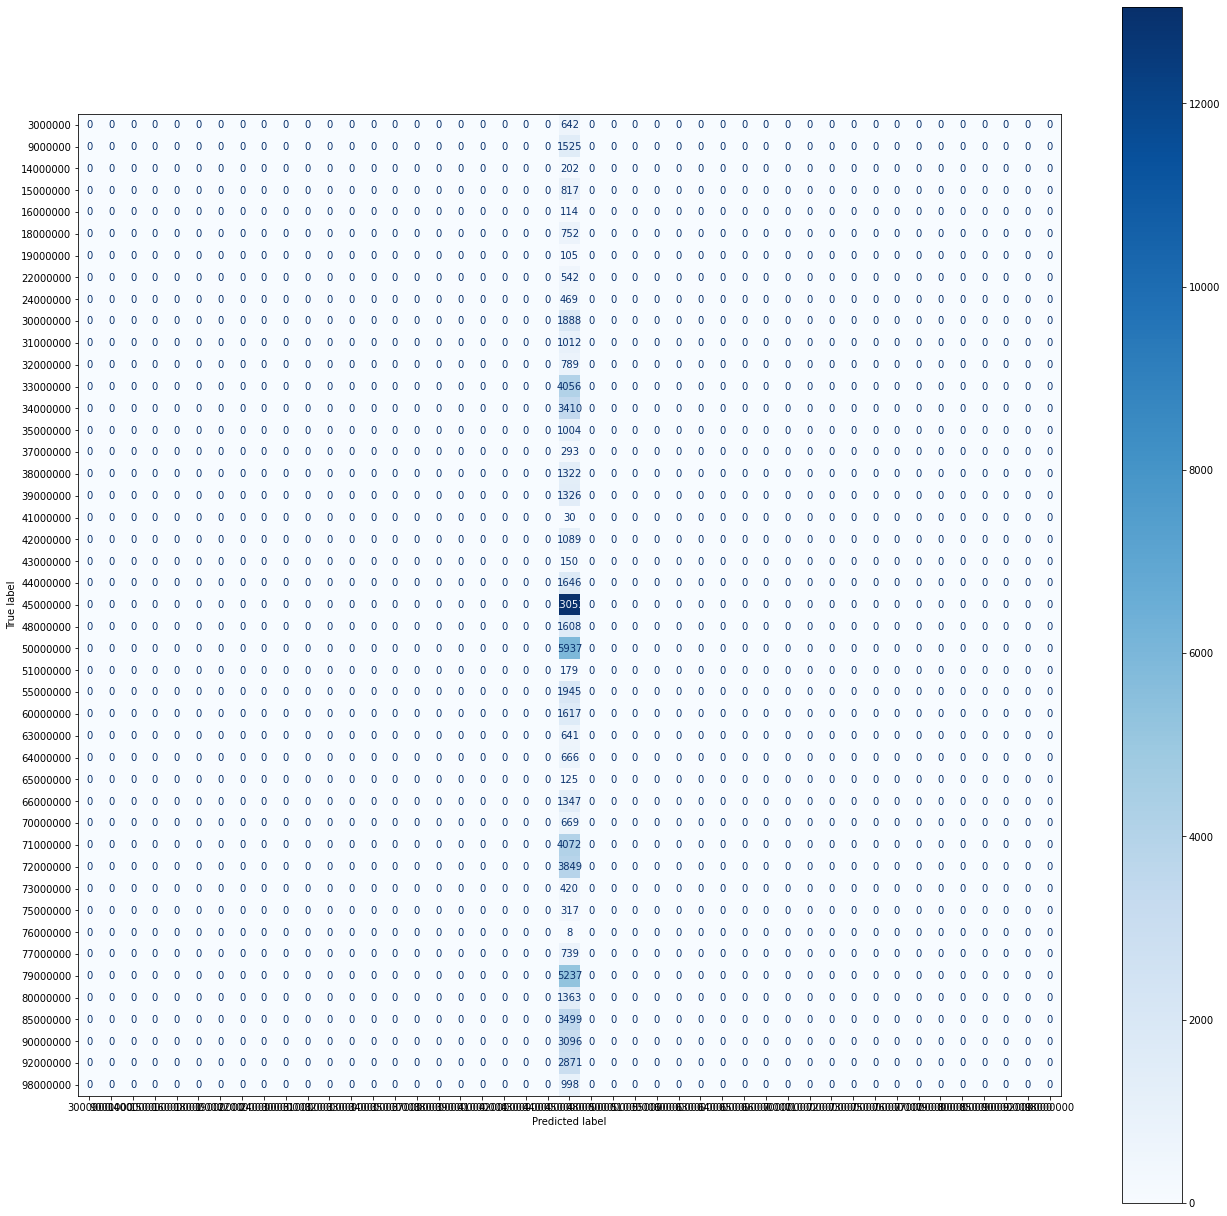

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##SGDClassifier

In [ ]:
#Model and hyperparameters
parametersSGD = { 
                 'max_iter':[200, 300, 500],
                 'loss':['modified_huber', 'squared_hinge', 'perceptron']
                 }
modelSGD = SGDClassifier(loss='perceptron', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [ ]:
#Model and hyperparameters
clf_GS_SGD = GridSearchCV(modelSGD, parametersSGD, cv=2, n_jobs=-1, verbose=10)
clf_GS_SGD.fit(X_train_SS, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 36.39, NNZs: 100, Bias: -2.026644, T: 278779, Avg. loss: 5.678839
Total training time: 0.22 seconds.
Norm: 73.49, NNZs: 100, Bias: -2.739654, T: 278779, Avg. loss: 16.596496
Total training time: 0.25 seconds.
-- Epoch 2
-- Epoch 2
Norm: 20.33, NNZs: 100, Bias: -2.023104, T: 557558, Avg. loss: 0.701643
Total training time: 0.64 seconds.
Norm: 37.92, NNZs: 100, Bias: -2.710272, T: 557558, Avg. loss: 1.696858
Total training time: 0.65 seconds.
-- Epoch 3
-- Epoch 3
Norm: 11.95, NNZs: 100, Bias: -2.019169, T: 836337, Avg. loss: 0.395981
Total training time: 1.04 seconds.
Norm: 27.17, NNZs: 100, Bias: -2.696740, T: 836337, Avg. loss: 0.935007
Total training time: 1.04 seconds.
-- Epoch 4
-- Epoch 4
Norm: 8.64, NNZs: 100, Bias: -2.017498, T: 1115116, Avg. loss: 0.278634
Total training time: 1.43 seconds.
Norm: 19.90, NNZs: 100, Bias: -2.687897, T: 1115116, Avg. loss: 0.684771
Total training time: 1.44 seconds.
-- Epoch 5
-- Epoch 5
Norm: 16.22, NNZs: 100, Bias: -2

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.1s


-- Epoch 1
-- Epoch 3
Norm: 9.47, NNZs: 100, Bias: -0.796498, T: 278779, Avg. loss: 14.777638
Total training time: 0.24 seconds.
Norm: 10.13, NNZs: 100, Bias: -1.402363, T: 836337, Avg. loss: 0.488026
Total training time: 1.09 seconds.
-- Epoch 2
-- Epoch 4
Norm: 4.52, NNZs: 100, Bias: -0.822775, T: 557558, Avg. loss: 1.745812
Total training time: 0.63 seconds.
Norm: 8.45, NNZs: 100, Bias: -1.401931, T: 1115116, Avg. loss: 0.341214
Total training time: 1.48 seconds.
-- Epoch 3
-- Epoch 5
Norm: 2.79, NNZs: 100, Bias: -0.832777, T: 836337, Avg. loss: 0.961825
Total training time: 1.03 seconds.
Norm: 6.38, NNZs: 100, Bias: -1.399648, T: 1393895, Avg. loss: 0.262311
Total training time: 1.86 seconds.
-- Epoch 4
-- Epoch 6
Norm: 2.24, NNZs: 100, Bias: -0.838576, T: 1115116, Avg. loss: 0.662837
Total training time: 1.45 seconds.
Norm: 5.57, NNZs: 100, Bias: -1.398224, T: 1672674, Avg. loss: 0.216149
Total training time: 2.26 seconds.
-- Epoch 5
Convergence after 6 epochs took 2.42 seconds
--

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.0min finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, loss='perceptron',
                                     n_jobs=-1, random_state=42, verbose=2),
             n_jobs=-1,
             param_grid={'loss': ['modified_huber', 'squared_hinge',
                                  'perceptron'],
                         'max_iter': [200, 300, 500]},
             verbose=10)

In [ ]:
# Let's see the results
y_pred = clf_GS_SGD.predict(X_test_SS)

In [ ]:
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'loss': 'modified_huber', 'max_iter': 200}

Grid scores on testing set:

0.446 (+/-0.035) for {'loss': 'modified_huber', 'max_iter': 200}
0.446 (+/-0.035) for {'loss': 'modified_huber', 'max_iter': 300}
0.446 (+/-0.035) for {'loss': 'modified_huber', 'max_iter': 500}
0.373 (+/-0.046) for {'loss': 'squared_hinge', 'max_iter': 200}
0.373 (+/-0.046) for {'loss': 'squared_hinge', 'max_iter': 300}
0.373 (+/-0.046) for {'loss': 'squared_hinge', 'max_iter': 500}
0.417 (+/-0.072) for {'loss': 'perceptron', 'max_iter': 200}
0.417 (+/-0.072) for {'loss': 'perceptron', 'max_iter': 300}
0.417 (+/-0.072) for {'loss': 'perceptron', 'max_iter': 500}

best score:  0.44611714879465314

Grid times on testing set:

53.931 seconds (+/-0.802) for {'loss': 'modified_huber', 'max_iter': 200}
53.991 seconds (+/-1.551) for {'loss': 'modified_huber', 'max_iter': 300}
53.450 seconds (+/-1.649) for {'loss': 'modified_huber', 'max_iter': 500}
53.336 se

In [ ]:
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'loss': 'modified_huber', 'max_iter': 100}

Grid scores on testing set:

0.446 (+/-0.035) for {'loss': 'modified_huber', 'max_iter': 100}

best score:  0.44611714879465314

Grid times on testing set:

54.862 seconds (+/-0.811) for {'loss': 'modified_huber', 'max_iter': 100}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.3903766908216346, 'accuracy': 0.49287826547346947}
              precision    recall  f1-score   support

          14       0.13      0.48      0.20       202
          15       0.79      0.37      0.50       817
          16       0.47      0.16      0.24       114
          18       0.72      0.35      0.47       752
          19       0.21      0.20      0.21       105
          22       0.35      0.55      0.43       542
          24       0.31      0.39      0.35       469
           3      

<Figure size 432x288 with 0 Axes>

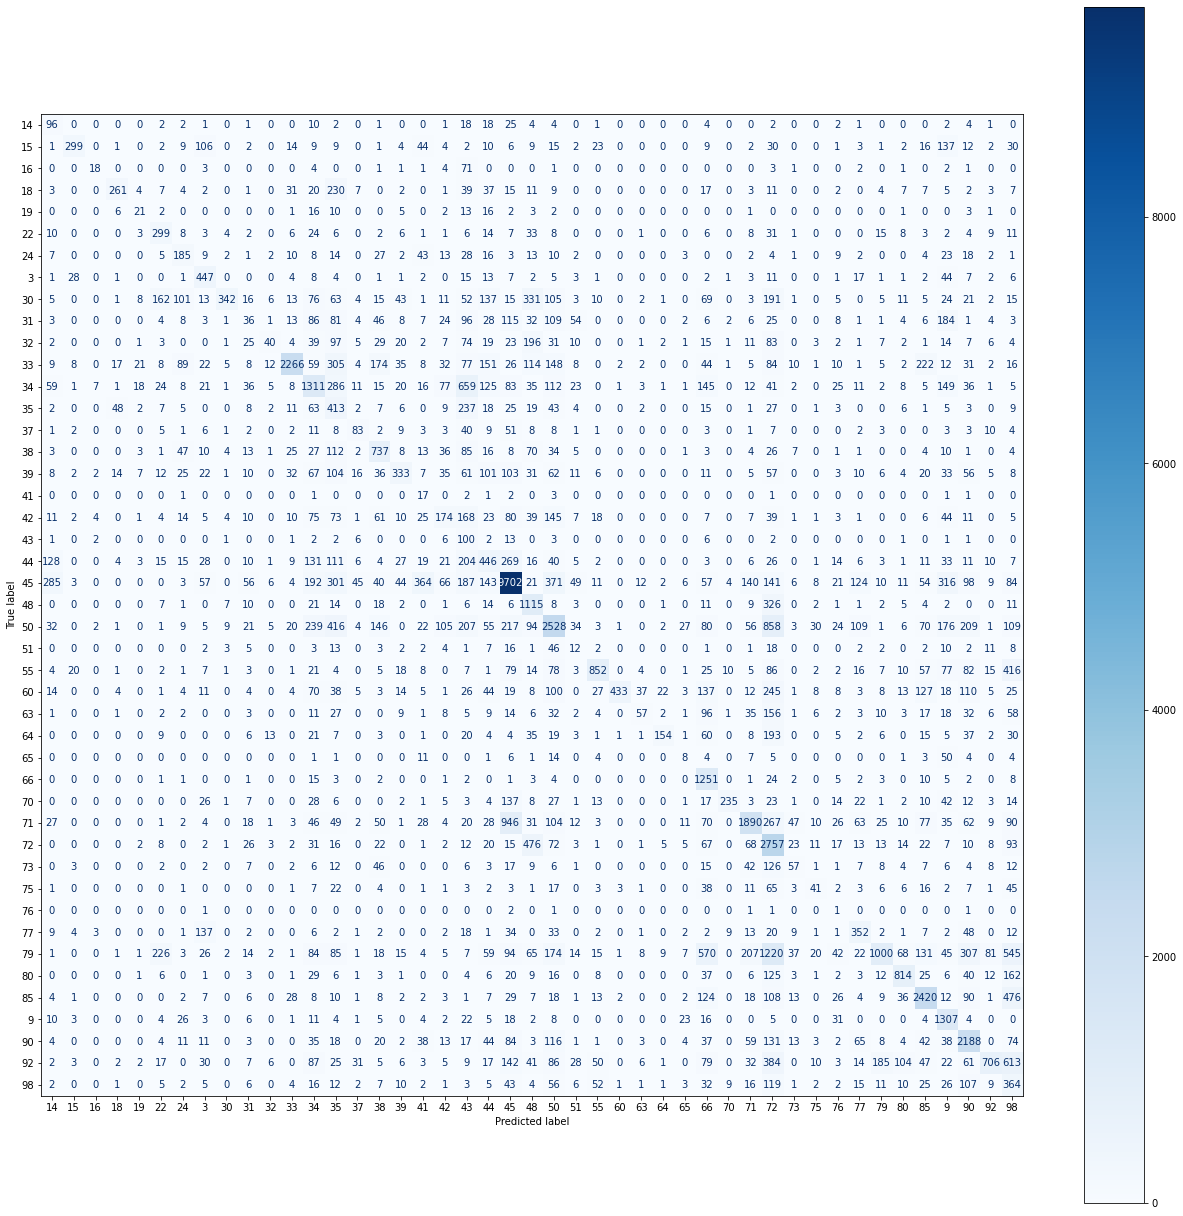

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     3000000       0.71      0.54      0.61       642
     9000000       0.59      0.91      0.72      1525
    14000000       0.30      0.44      0.36       202
    15000000       0.75      0.70      0.72       817
    16000000       0.42      0.37      0.39       114
    18000000       0.59      0.63      0.61       752
    19000000       0.31      0.26      0.28       105
    22000000       0.41      0.60      0.49       542
    24000000       0.41      0.55      0.47       469
    30000000       0.52      0.70      0.59      1888
    31000000       0.41      0.20      0.27      1012
    32000000       0.35      0.40      0.37       789
    33000000       0.80      0.80      0.80      4056
    34000000       0.63      0.62      0.63      3410
    35000000       0.38      0.39      0.38      1004
    37000000       0.29      0.49      0.37       293
    38000000       0.40      0.72      0.51      1322
    39000000       0.49    

<Figure size 432x288 with 0 Axes>

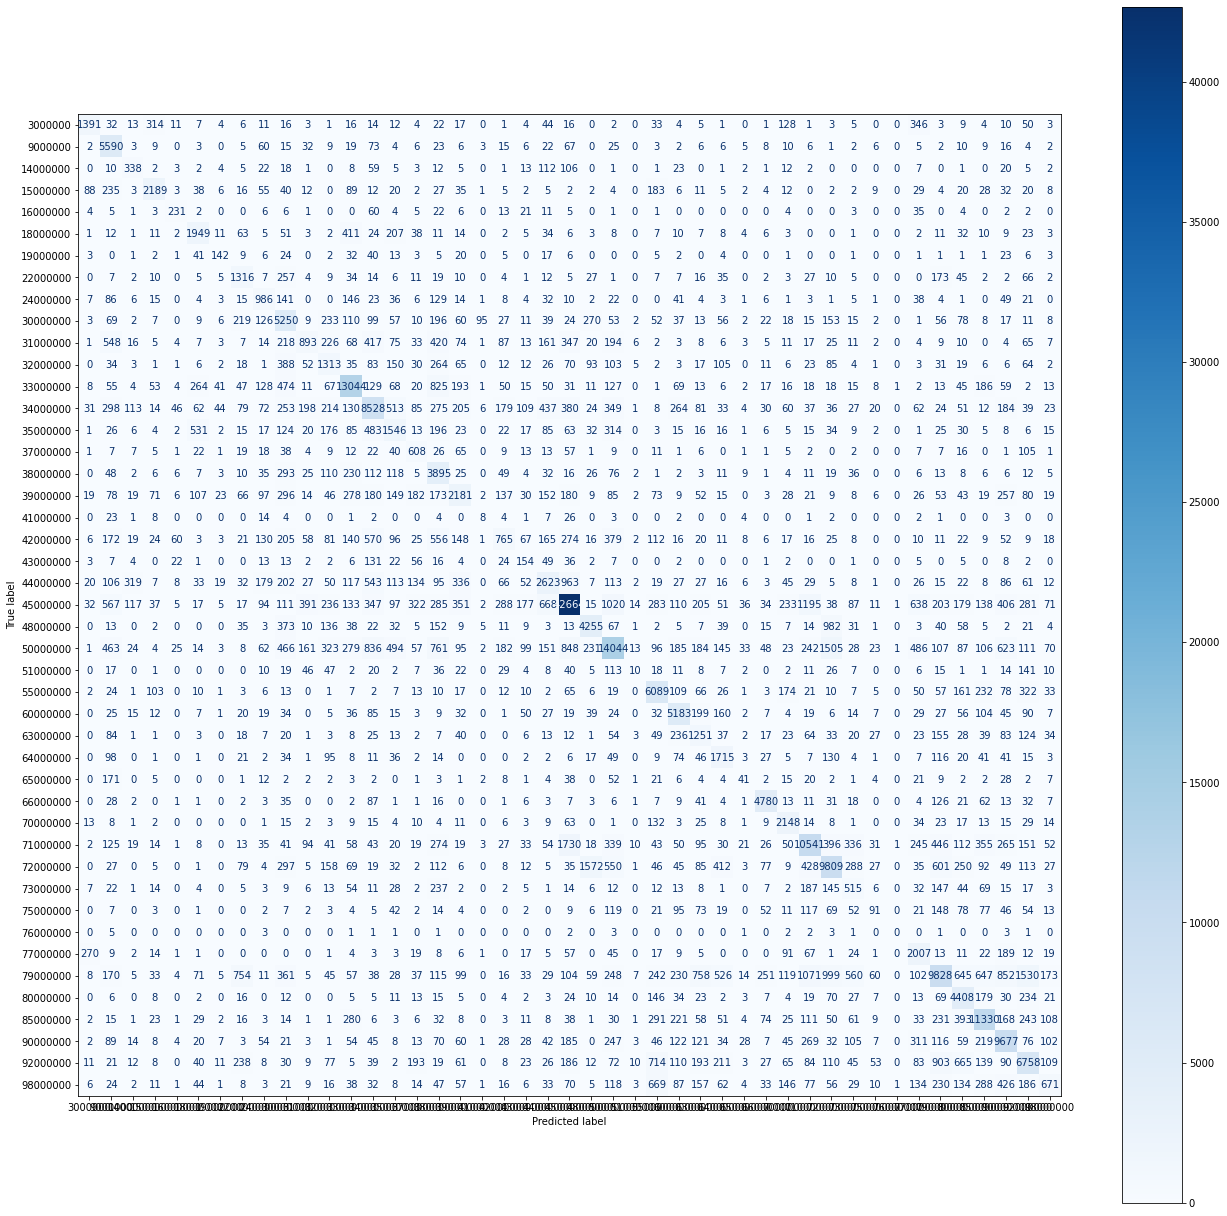

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(22,22))
ConfusionMatrixDisplay.from_estimator(model, X_train_w2v, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

<Figure size 432x288 with 0 Axes>

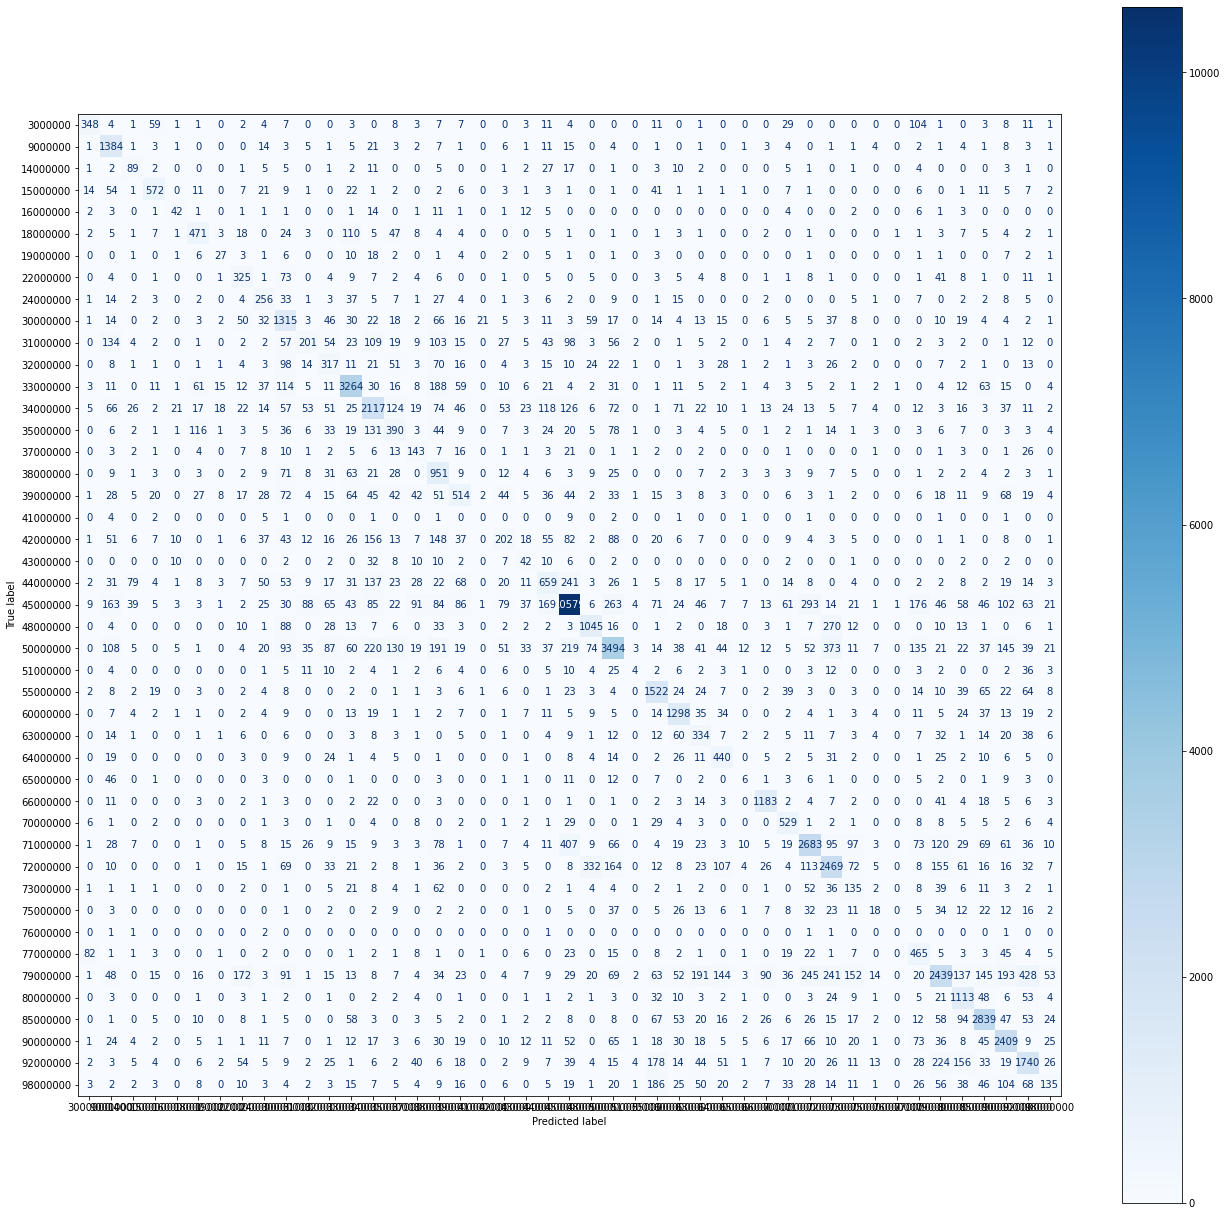

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(22,22))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = [preprocessing(example) for example in examples]
examples

[['semillas', 'para', 'siembra'],
 ['alquiler', 'bar', 'del', 'paramo'],
 ['obras', 'metro', 'remodelacion'],
 ['materiales', 'papeleria', 'oficina'],
 ['gruas', 'para', 'demolicion'],
 ['gruas', 'para', 'demolicion']]

In [ ]:
examples = [vectorize_sentence(example, w2v_embeddings) for example in examples]

In [ ]:
examples = scaler.transform(examples)

In [ ]:
#Prediction
test = model.predict(examples)
test

array([16000000, 55000000, 45000000, 30000000, 43000000, 43000000])